In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from extraction_bam import *

In [3]:
gain=3.853           # gain [e-/ADU]
readnoise=8.365785291814616 # readout noise [e-]
bias=2576            # bias [ADU]

# Data Acquisition

In [4]:
obsfiles=['../../datasets/gbins/bam/2017-07-02/BamObservation_000-000-{:03d}.gbin'.format(n) for n in range(19,50)]
obsfile = obsfiles[1]

#obsfiles=['../../datasets/gbins/bam/09-2017/BamObservation_000-000-{:03d}.gbin'.format(n) for n in range(0,20)]
#obsfile = obsfiles[9] # flare starts at the end of 8

nobs = 512 # how many obs we want to do - although this is an upper limit (chosen as max nr. of extensions for fits)
i_obs = 0

In [5]:
i_obs = 0

# make two boxcars
boxrad = 3

boxcar0 = BoxCar(boxrad=boxrad, fov=1)
boxcar1 = BoxCar(boxrad=boxrad, fov=2)

# fill them

# open the reader
reader = gbin_reader.GbinReader(obsfile)

# record acquisition times

# fill the first few elements
while True:
    (pattern, fov, acqTime) = bam_read_obs(reader, bias, gain)
    if fov == None:
        break  # should raise an error here - this should never happen
    if fov==0 and boxcar0.nfilled < boxcar0.npatterns:
        boxcar0.update(pattern, acqTime)
        boxcar0.nfilled+=1
    elif fov==1 and boxcar1.nfilled < boxcar1.npatterns:
        boxcar1.update(pattern, acqTime)
        boxcar1.nfilled+=1

    i_obs += 1
    print(i_obs)
    if (boxcar0.nfilled >= boxcar0.npatterns and boxcar1.nfilled >= boxcar1.npatterns) or (i_obs >= nobs):
        # in the second case, we may want to give some alarm
        break

# set the i_sig
boxcar0.i_sig = boxcar0.boxrad
boxcar1.i_sig = boxcar1.boxrad

1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [6]:
# let's test the execution time of this part - it takes the most time
import time
tstart = time.time()


# extract the cosmics
out0 = []
out1 = []

while ((i_obs < nobs) and fov !=None):
    # extract cosmics from fov 0 and 1 and save them
    sig, err, N_mask = boxcar0.get_signal(readnoise)
    output = bam_cosmics(sig, err, 4, 0.5, N_mask, gain)
    
    # update the keys
    output.acqTime = boxcar0.acqTimes[boxcar0.i_sig]
    output.row=1  # is this always true?
    output.fov=boxcar0.fov
    output.gain=gain
    out0.append(output)
    
    sig, err, N_mask = boxcar1.get_signal(readnoise)
    output = bam_cosmics(sig, err, 4, 0.5, N_mask, gain)
    
    # update the headers
    output.acqTime = boxcar1.acqTimes[boxcar1.i_sig]
    output.row=1  # is this always true?
    output.fov=boxcar1.fov
    output.gain=gain
    out1.append(output)
    
    # update the boxcars
    for ii in range(2):
        (pattern, fov, acqTime) = bam_read_obs(reader, bias, gain)
        if fov == None:
            break  # we're finished
        if fov==0:
            boxcar0.update(pattern, acqTime)
        elif fov==1:
            boxcar1.update(pattern, acqTime)
        i_obs += 1
        print(i_obs)
        
        
tend = time.time()
print("Elapsed time:", tend - tstart)

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
Elapsed time: 33.84361171722412


# Saving the data

In [184]:
from astropy.io import fits

In [ ]:
# for now, combine out0 and out1
# time it
import time
tstart = time.time()


out = []
for ii in range(len(out0)):
    out.append(out0[ii])
    out.append(out1[ii])

outfile = 'output_test_flare.fits'
write_Obslist(out, outfile)


tend = time.time()
print("Elapsed time:", tend - tstart)

# Reading data

In [18]:
import time
tstart = time.time()

inlist = read_Obslist_fits('output_test.fits')

tend = time.time()
print("Elapsed time:", tend - tstart)

Elapsed time: 1.7078661918640137


# Some diagnostics

In [7]:
print(len(out0[0].data))
#print(out0[0][9])

103


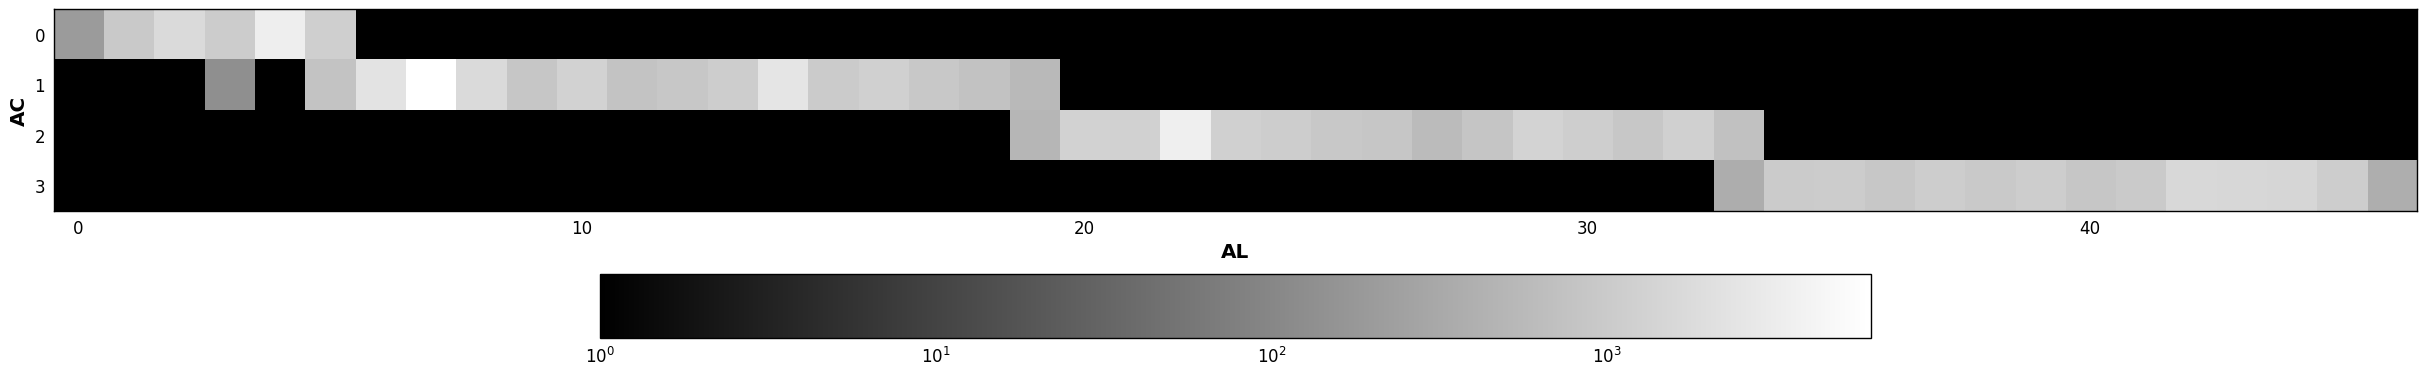

In [9]:
i_obs = 0
i_track = 9

track = out0[0].data[i_track]["TRACK"]
dims = (out0[0].data[i_track]["DIM_AL"],out0[0].data[i_track]["DIM_AC"])
image = np.rot90(np.reshape(track, dims))

plt.xlabel('AL')
plt.ylabel('AC')
#plt.imshow(image, cmap='gray',vmin=4, vmax=4.1)
plt.imshow(image+1, cmap='gray',vmin=1,norm=LogNorm())
plt.gcf().set_size_inches(30.5, 5.5)
plt.colorbar(orientation="horizontal")
plt.grid(False)

In [10]:
# This should be quite a lot of energies, so do a histogram

E0 = []
E1 = []

# also for lengths, why not
AL0 = []
AL1 = []
AC0 = []
AC1 = []

for ii in range(len(out0)):
    E0 += list(out0[ii].data["TRACK_EN"])
    AL0 += list(out0[ii].data["DIM_AL"]-1)
    AC0 += list(out0[ii].data["DIM_AC"]-1)
    E1 += list(out1[ii].data["TRACK_EN"])
    AL1 += list(out1[ii].data["DIM_AL"]-1)
    AC1 += list(out1[ii].data["DIM_AC"]-1)

E0 = np.array(E0)
E1 = np.array(E1)
AL0 = np.array(AL0)
AC0 = np.array(AC0)
AL1 = np.array(AL1)
AC1 = np.array(AC1)

        
# number of cosmics
print("FOV 0:", len(E0), "cosmics")
print("FOV 1:", len(E1), "cosmics")

FOV 0: 10383 cosmics
FOV 1: 10512 cosmics


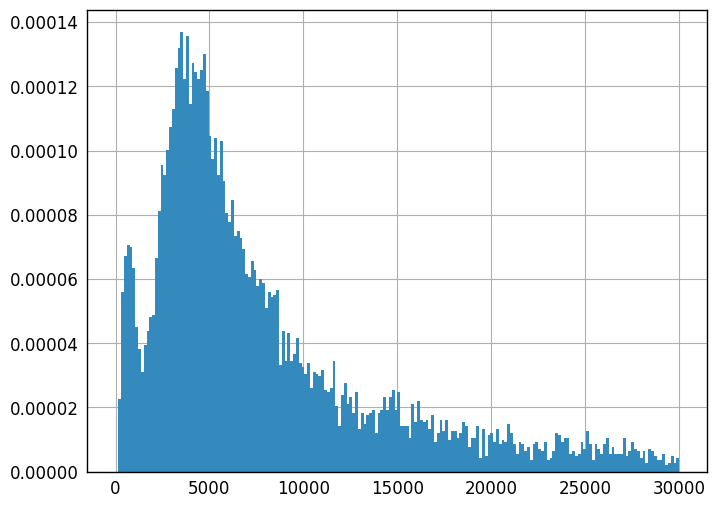

In [11]:
hist0 = plt.hist(E0, 200, log=False ,range=(0,30000), normed=True)

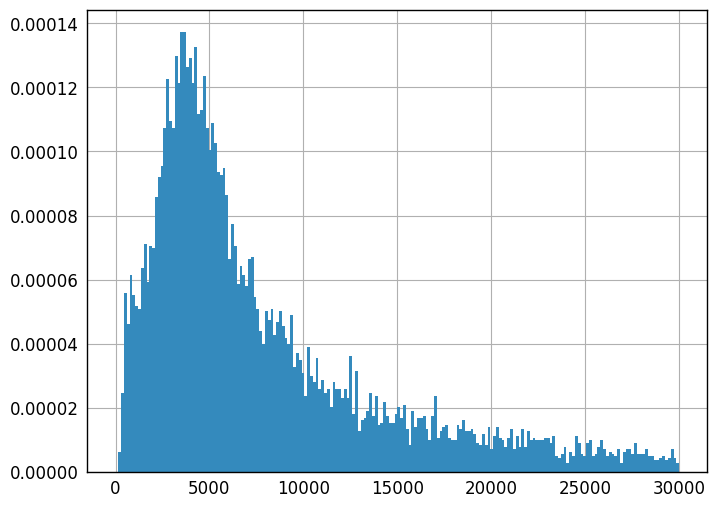

In [12]:
hist1 = plt.hist(E1, 200, log=False ,range=(0,30000), normed=True)

In [13]:
# Let's try the angles
# For now without how it faces

lx = AL0*10  # mum
ly = AC0*120 # mum

theta = np.zeros(lx.shape)

nonzero = np.logical_and(lx!=0, ly!=0)
theta[nonzero] = np.arctan(ly[nonzero]/lx[nonzero])*180/np.pi

theta[lx==0] = 5000  # 90
theta[ly==0] = 5000  # 0
theta[np.logical_and(lx==0, ly==0)] = 5000  # ignore for now

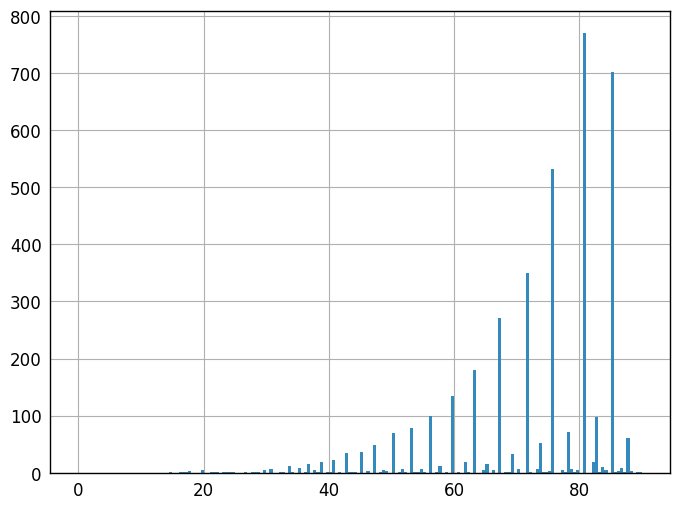

In [14]:
thist = plt.hist(theta,180,range=(0,90))

-> VERY biased

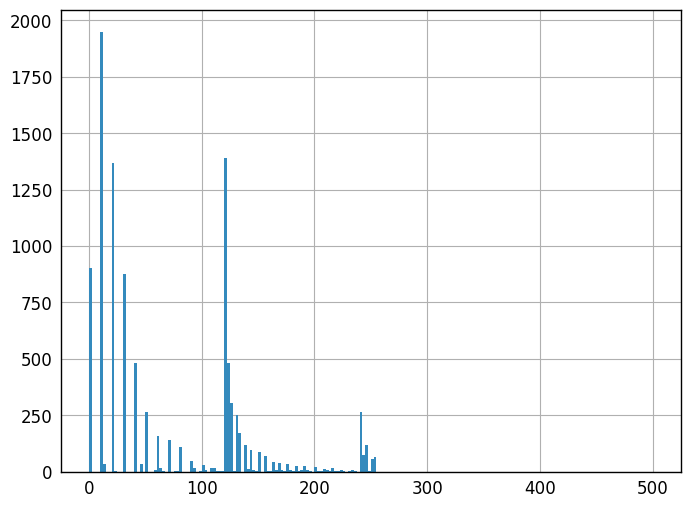

In [15]:
lengths = np.sqrt(lx*lx + ly*ly)

thist = plt.hist(lengths,200,range=(0,500),log=False)

One sees individual contributions from the length in AC and AL.

Fun estimation: Let's see if dE/dx gives us anything

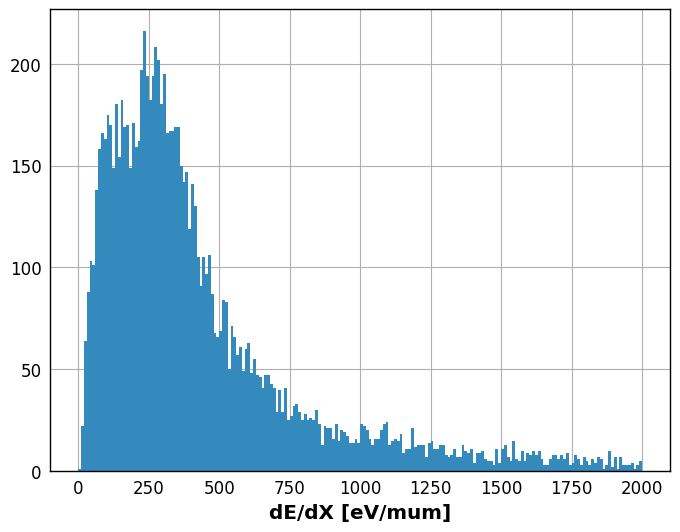

In [16]:
dEdx = E0/np.sqrt(lengths**2+40**2) # assuming our length measurement is good and we excite the whole detector

dEdx *= 3.6   # energy (eV) per electron/hole pair

thist = plt.hist(dEdx,200,log=False,range=(0,2000))
plt.xlabel("dE/dX [eV/mum]")

I have to say, this looks remarkably like a landau distribution.

(It should not be, since we have multiple particle species/energies)

-> For normal obs: maximum at about 250 eV/mum = 2.5 MeV/cm = (for silicon) about 1 MeV cm2 / g

-> Minimum Ionizing Particle? That's about 1 GeV!

-> For Flare: also very Landau, max at about 500 eV/mum = 5 MeV/cm = 2 MeV cm2 / g

-> Either higher or lower energies - hard to say, since close to MIP

(Note: This is still all very suspect)

However, it's actually consistent with the paper by Jos using the Creme-background of the GCR (1 GeV) and Spenvis solar protons (10-10^2 MeV)...

In [17]:
acqTimes = []

for ii in range(len(out0)):
    acqTimes.append(out0[ii].acqTime)
    
acqTimes = np.array(acqTimes)
# both fov have the same acqTime

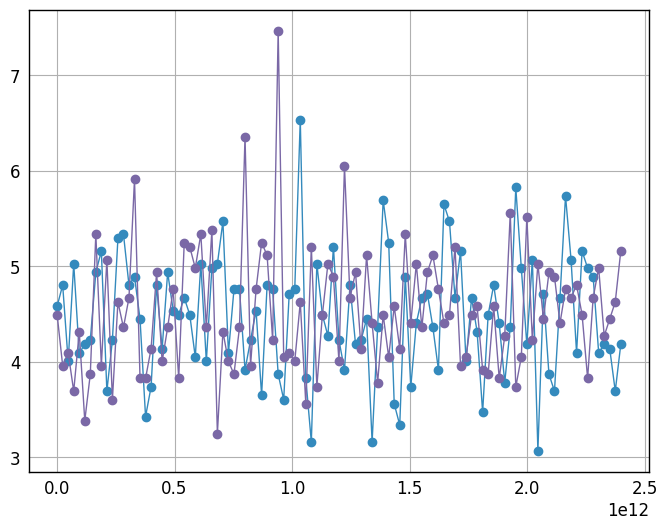

In [18]:
# fluxes
flux0 = [obs.calculate_flux() for obs in out0]
flux1 = [obs.calculate_flux() for obs in out1]

plt.plot(acqTimes-acqTimes[0],flux0,marker='o')
plt.plot(acqTimes-acqTimes[0],flux1,marker='o')

In [19]:
# for fun - make a cosmic ray image from a TrackObs


obs = out0[-1]

image = np.zeros((obs.srcAL,obs.srcAC))

for ii in range(len(obs.data)):
    track = np.reshape(obs.data[ii]["TRACK"], (obs.data[ii]["DIM_AL"],obs.data[ii]["DIM_AC"]))
    start_AL = obs.data[ii]["LOC_AL"]
    stop_AL = obs.data[ii]["LOC_AL"] + obs.data[ii]["DIM_AL"]
    start_AC = obs.data[ii]["LOC_AC"]
    stop_AC = obs.data[ii]["LOC_AC"] + obs.data[ii]["DIM_AC"]
    image[start_AL:stop_AL,start_AC:stop_AC] += track

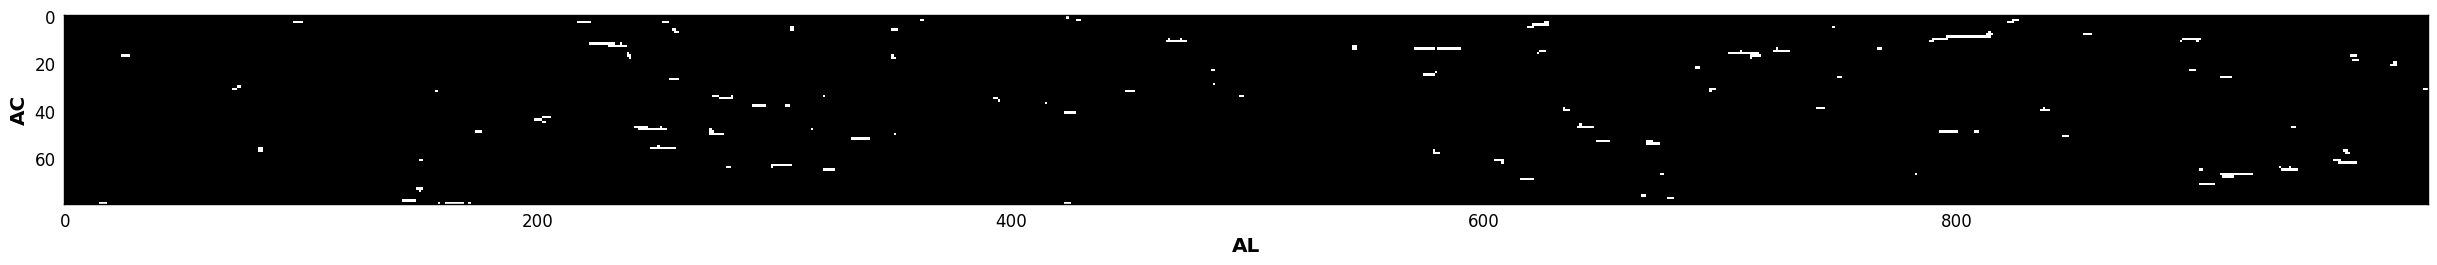

In [20]:
im=np.rot90(image,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(im, cmap='gray',vmax=20)#,aspect=12)
#plt.imshow(image[30:60,70:120], cmap='gray')
plt.gcf().set_size_inches(30.5, 5.5)
#plt.colorbar(orientation="horizontal")
plt.grid(False)